In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks, hilbert
from scipy.integrate import odeint

# === Load EEG data (replace with your path) ===
file_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/EEG.csv"
EEG = pd.read_csv(file_path)

real_data_path = "/Users/kasunachinthaperera/Documents/VS Code/Complex Network/Data/Epileptogenic_Results.csv"
df = pd.read_csv(real_data_path)


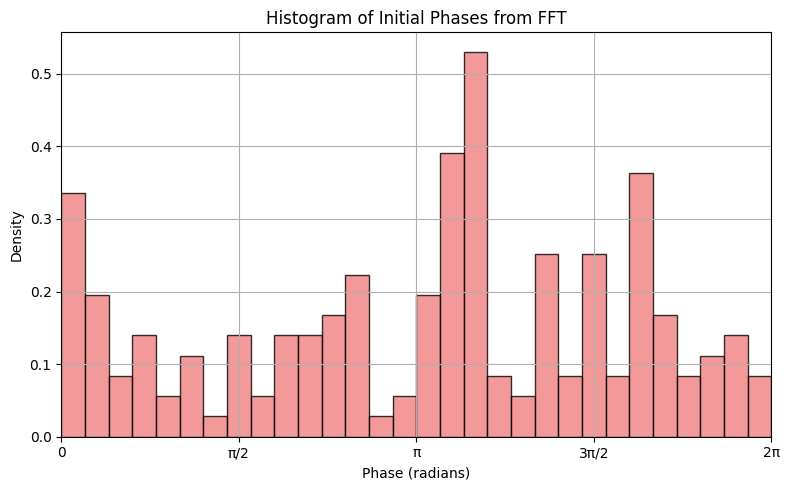

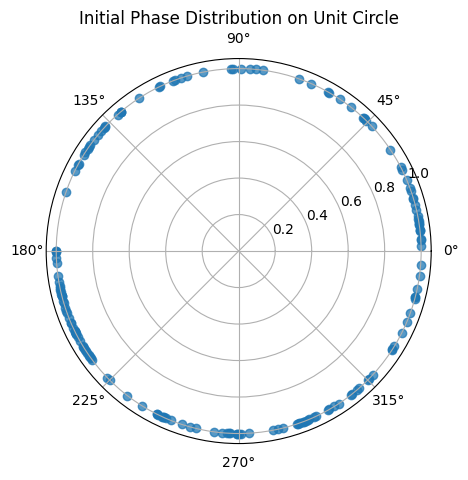

In [8]:
# Initial Phase Distribution
import numpy as np
import pandas as pd

# === Parameters ===
fs = 500     # Sampling rate

# === Extract EEG info ===
channels = EEG.columns
N = len(channels)

# === Step 1: Get initial phases using FFT-based method ===
initial_phases = []
for channel in EEG.columns:
    signal = EEG[channel].values
    fft_vals = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=1/fs)

    # Consider only positive frequencies between 0.5 and 100 Hz
    mask = (freqs >= 0.5) & (freqs <= 100)
    fft_band = fft_vals[mask]
    freqs_band = freqs[mask]

    # Find the dominant frequency component
    peak_idx = np.argmax(np.abs(fft_band))
    phase = np.angle(fft_band[peak_idx])
    wrapped_phase = np.mod(phase, 2 * np.pi)  # Wrap to [0, 2π]
    initial_phases.append(wrapped_phase)

initial_phases = np.array(initial_phases)

x = np.array(initial_phases)  # Initial phases (fixed during TLE calculation)

# Wrap phase values to the range [0, 2π)
x = np.mod(x, 2 * np.pi)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(x, bins=30, density=True, color='lightcoral', edgecolor='black', alpha=0.8, range=(0, 2*np.pi))
plt.title("Histogram of Initial Phases from FFT")
plt.xlabel("Phase (radians)")
plt.ylabel("Density")
plt.xlim([0, 2*np.pi])
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', 'π/2', 'π', '3π/2', '2π'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Polar plot of final wrapped phases ===
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)
ax.scatter(x, np.ones_like(x), alpha=0.75)
ax.set_title(f'Initial Phase Distribution on Unit Circle')
plt.show()

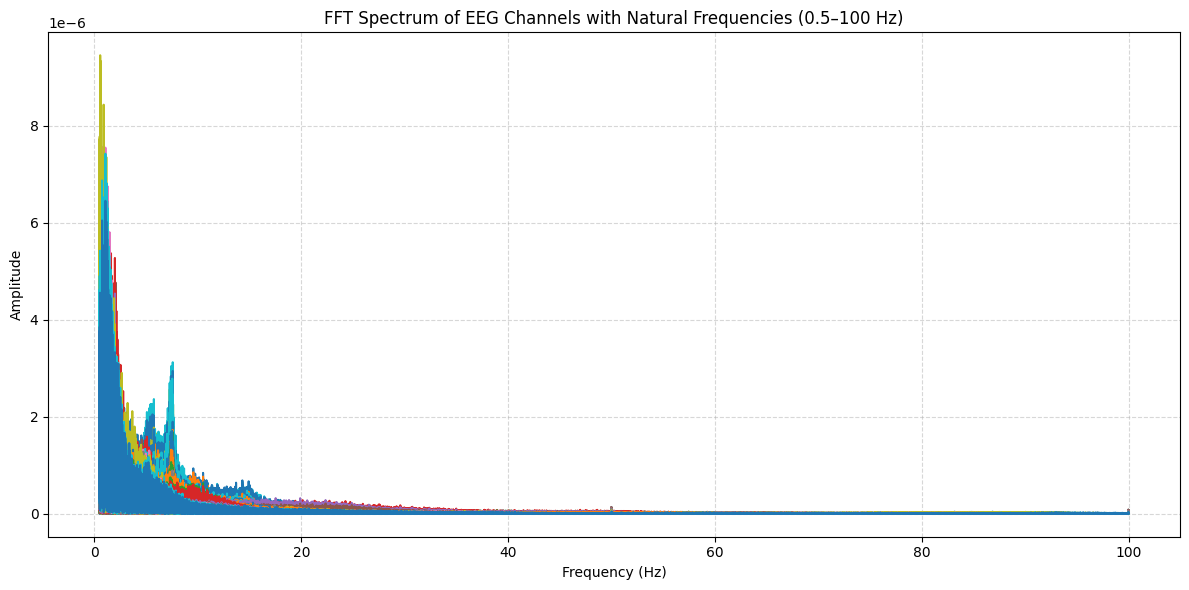

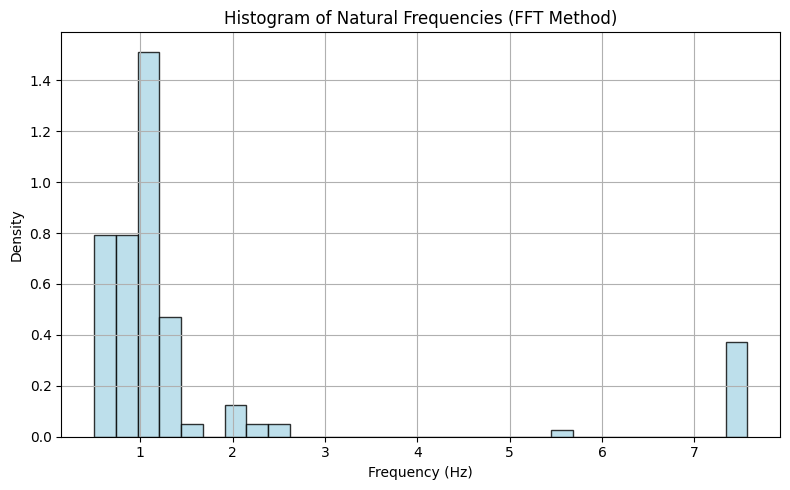

In [9]:
import numpy as np
import matplotlib.pyplot as plt

fs = 500  # Sampling frequency (Hz)
natural_freqs_fft = []

plt.figure(figsize=(12, 6))

for i, channel in enumerate(EEG.columns):
    signal = EEG[channel].values
    fft_vals = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(fft_vals), d=1/fs)
    amplitude = np.abs(fft_vals) / len(signal)

    # Frequency range: 0.5 Hz to 100 Hz
    freq_mask = (freqs >= 0.5) & (freqs <= 100)
    freqs_range = freqs[freq_mask]
    amplitude_range = amplitude[freq_mask]

    # Extract peak frequency in this band
    peak_idx = np.argmax(amplitude_range)
    natural_freq = freqs_range[peak_idx]
    natural_freqs_fft.append(natural_freq)

    # Plot FFT spectrum
    plt.plot(freqs_range, amplitude_range, label=f"{channel} (f={natural_freq:.2f} Hz)")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT Spectrum of EEG Channels with Natural Frequencies (0.5–100 Hz)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
# plt.legend(loc='upper right', fontsize='small')  # Optional: Enable if few channels
plt.tight_layout()
plt.show()

# === Plot Histogram of Natural Frequencies ===
natural_freqs_fft = np.array(natural_freqs_fft)
plt.figure(figsize=(8, 5))
plt.hist(natural_freqs_fft, bins=30, density=True, color='lightblue', edgecolor='black', alpha=0.8)
plt.title("Histogram of Natural Frequencies (FFT Method)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()


Estimated g(omega): 0.4805
Estimated critical coupling ε_c: 1.3248


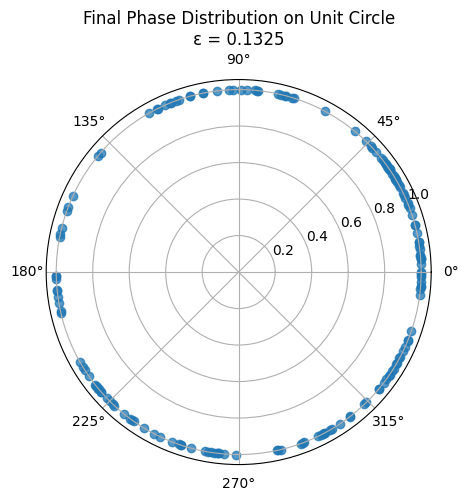

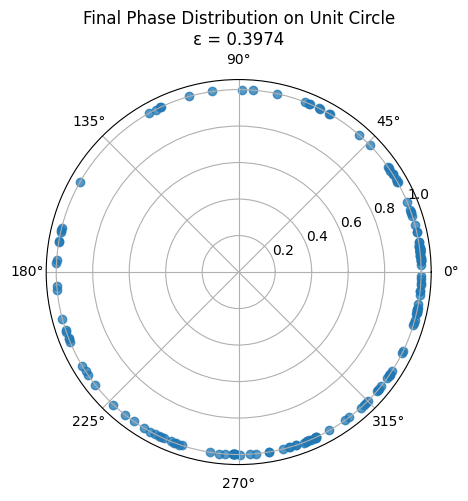

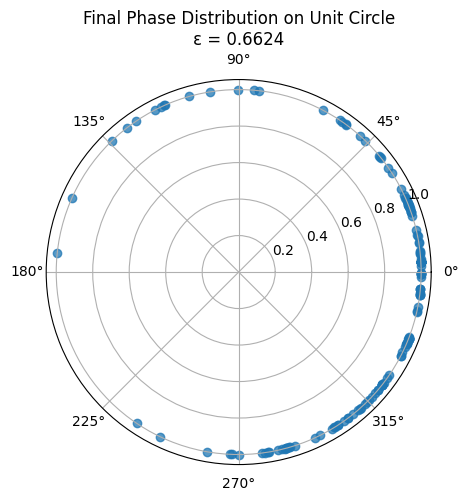

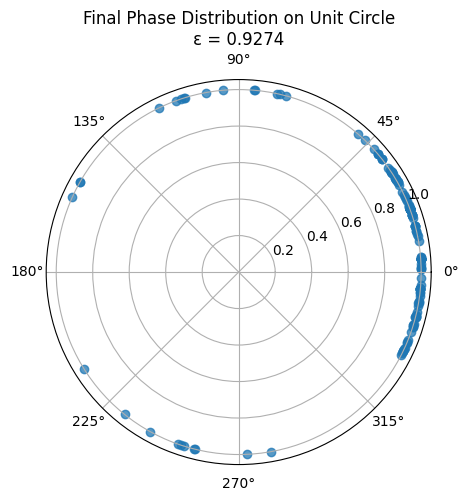

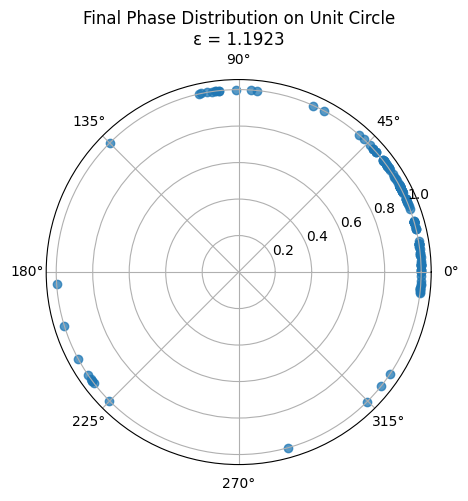

In [10]:
# Kuramoto model simulation with FFT-derived natural frequencies with critical epsilon - 02
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.stats import gaussian_kde

# === Parameters ===
fs = 500  # Sampling frequency (Hz)
T_sim = 1500  # Number of time steps
dt = 0.01  # Time step size

# === Compute natural frequencies using FFT ===
natural_freqs_fft = []
N = len(EEG.columns)

for channel in EEG.columns:
    signal = EEG[channel].values
    fft_vals = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(fft_vals), d=1/fs)
    amplitude = np.abs(fft_vals) / len(signal)

    # Restrict to 0.5–100 Hz range
    mask = (freqs >= 0.5) & (freqs <= 100.0)
    freqs_band = freqs[mask]
    amplitude_band = amplitude[mask]

    # Identify peak frequency in range
    peak_idx = np.argmax(amplitude_band)
    natural_freq = freqs_band[peak_idx]
    natural_freqs_fft.append(natural_freq)

# Use FFT-derived frequencies
natural_freqs_fft = np.array(natural_freqs_fft)
omega = natural_freqs_fft # Natural frequencies (fixed during TLE calculation)

# === Step 2: Estimate g(omega) and critical epsilon ===
kde = gaussian_kde(omega)
density_values = kde.evaluate(omega)
g_omega = np.max(density_values)
epsilon_critical = 2 / (np.pi * g_omega)

print(f"Estimated g(omega): {g_omega:.4f}")
print(f"Estimated critical coupling ε_c: {epsilon_critical:.4f}")

epsilons = np.linspace(0.1 * epsilon_critical, 0.9 * epsilon_critical, 5)

initial_phases = []
for channel in EEG.columns:
    signal = EEG[channel].values
    fft_vals = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=1/fs)

    # Consider only positive frequencies between 0.5 and 100 Hz
    mask = (freqs >= 0.5) & (freqs <= 100)
    fft_band = fft_vals[mask]
    freqs_band = freqs[mask]

    # Find the dominant frequency component
    peak_idx = np.argmax(np.abs(fft_band))
    phase = np.angle(fft_band[peak_idx])
    wrapped_phase = np.mod(phase, 2 * np.pi)  # Wrap to [0, 2π]
    initial_phases.append(wrapped_phase)

initial_phases = np.array(initial_phases)

for epsilon in epsilons:
    x = np.array(initial_phases)
    phase_history = np.zeros((T_sim, N))
    phase_history[0] = x

    # === Simulate phase dynamics (Kuramoto model) ===
    for t in range(1, T_sim):
        x_new = np.copy(x)
        for k in range(N):
            coupling_sum = np.sum(np.sin(x - x[k])) - np.sin(0)  # Exclude self-term
            x_new[k] += dt * (omega[k] + (epsilon / N) * coupling_sum)
        x = x_new
        phase_history[t] = x

    # === Plot 3: Polar plot of final wrapped phases ===
    final_phases = np.mod(phase_history[-1], 2 * np.pi)
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(111, polar=True)
    ax.scatter(final_phases, np.ones_like(final_phases), alpha=0.75)
    ax.set_title(f'Final Phase Distribution on Unit Circle\nε = {epsilon:.4f}')
    plt.show()


In [11]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.utils import resample

# Assuming `omega` is your array of natural frequencies
n_bootstraps = 1000
g_omega_values = []

# Bootstrap resampling
for _ in range(n_bootstraps):
    omega_sample = resample(omega)
    kde = gaussian_kde(omega_sample)
    density_values = kde.evaluate(omega_sample)
    g_omega_values.append(np.max(density_values))

g_omega_values = np.array(g_omega_values)
g_omega_mean = np.mean(g_omega_values)
g_omega_std = np.std(g_omega_values)

epsilon_critical_values = 2 / (np.pi * g_omega_values)
epsilon_critical_mean = np.mean(epsilon_critical_values)
epsilon_critical_std = np.std(epsilon_critical_values)

print(f"Estimated g(omega): {g_omega_mean:.4f} ± {g_omega_std:.4f}")
print(f"Critical coupling ε_c ≈ {epsilon_critical_mean:.4f} ± {epsilon_critical_std:.4f}")


Estimated g(omega): 0.4885 ± 0.0591
Critical coupling ε_c ≈ 1.3213 ± 0.1526


In [12]:
# Epileptogenic comparison from real EEG data - FFT Phase Method
import numpy as np
import pandas as pd

# === Parameters ===
epsilon = 0.5 * epsilon_critical  # Coupling strength
fs = 500     # Sampling rate

# === Extract EEG info ===
channels = EEG.columns
N = len(channels)

# === Step 1: Get initial phases using FFT-based method ===
initial_phases = []
for channel in EEG.columns:
    signal = EEG[channel].values
    fft_vals = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=1/fs)

    # Consider only positive frequencies between 0.5 and 100 Hz
    mask = (freqs >= 0.5) & (freqs <= 100)
    fft_band = fft_vals[mask]
    freqs_band = freqs[mask]

    # Find the dominant frequency component
    peak_idx = np.argmax(np.abs(fft_band))
    phase = np.angle(fft_band[peak_idx])
    wrapped_phase = np.mod(phase, 2 * np.pi)  # Wrap to [0, 2π]
    initial_phases.append(wrapped_phase)

initial_phases = np.array(initial_phases)

x = np.array(initial_phases)  # Initial phases (fixed during TLE calculation)

# === Step 2: Compute TLEs for each channel ===
TLEs = np.zeros(N)
for k in range(N):
    cos_sum = 0
    for j in range(N):
        if j != k:
            cos_sum += np.cos(x[j] - x[k])
    TLEs[k] = - (epsilon / N) * cos_sum

# === Step 3: Threshold TLEs to determine simulated epileptogenicity ===
# Stable (TLE ≤ 0): 1 = Epileptogenic
# Unstable (TLE > 0): 0 = Non-epileptogenic
Epileptogenic_simulated = (TLEs <= 0).astype(int)
Epileptogenic_sim = np.column_stack((channels, Epileptogenic_simulated.astype(str)))

# Ensure columns match EEG channels
Epileptogenic_real = np.column_stack((channels, df['Epileptogenic'].to_numpy().astype(str)))

# === Step 5: Cross-tabulation of simulation vs real labels ===
sim_vals = Epileptogenic_sim[:, 1].astype(int)
real_vals = Epileptogenic_real[:, 1].astype(int)

cross_table = np.zeros((2, 2), dtype=int)
for s, r in zip(sim_vals, real_vals):
    cross_table[s, r] += 1

# Format using pandas for readability
df_cross = pd.DataFrame(cross_table,
                        index=['Sim=0 (Non-Epi)', 'Sim=1 (Epi)'],
                        columns=['Real=0 (Non-Epi)', 'Real=1 (Epi)'])

print("\nCross-tabulation Results using FFT (Simulated vs Real Epileptogenicity):")
print(df_cross)



Cross-tabulation Results using FFT (Simulated vs Real Epileptogenicity):
                 Real=0 (Non-Epi)  Real=1 (Epi)
Sim=0 (Non-Epi)                61            12
Sim=1 (Epi)                    58            40
